In [1]:
import pandas as pd
import numpy as np
import re
import json
import matplotlib.pyplot as plt
import glob, os, csv

from langdetect import detect

import gensim
from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import CoherenceModel

from pprint import pprint

import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'http', 'javascript', 'onion', 'site', 'com'])

from bs4 import BeautifulSoup

# import pyLDAvis
# import pyLDAvis.gensim

import ast
from collections import Counter
from operator import add
from wordcloud import WordCloud

# import stanza
# # stanza.download('en')
# nlp = stanza.Pipeline('en', processors='tokenize,mwt,pos,lemma')

from sklearn.model_selection import train_test_split
import math
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier, StackingClassifier, AdaBoostClassifier
import seaborn as sns
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [2]:
# Preprocessing

In [3]:
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text))

def preprocess(sentences):
    result = []
    
    for sent in sentences:
        lemmas = []
        # tokenize
        tokens = gensim.utils.simple_preprocess(sent)
        for token in tokens:
            lemma = lemmatize_stemming(token)
            # remove stopwords
            if lemma not in stop_words:
                lemmas.append(lemma)
        # POS tagging
        nltk_tagged = nltk.pos_tag(lemmas)
        for word, tag in nltk_tagged:
#             result.append(word)
            # only keep nouns
            if tag.startswith('N'):
                result.append(word)
    return result

In [4]:
def language_detect(ls):
    text = ' '.join(ls)
    result = detect(text)
    return result

In [5]:
df_labelled = pd.read_csv('../data/trainset_combined.csv')
df_unlabelled = pd.read_csv('../data/testset.csv')
df_labelled.drop(columns='Unnamed: 0', inplace=True)
df_unlabelled.drop(columns='Unnamed: 0', inplace=True)
# convert the string representation of a list into a list
df_labelled['body_text'] = df_labelled['body_text'].apply(ast.literal_eval)
df_labelled['body_token'] = df_labelled['body_token'].apply(ast.literal_eval)
df_labelled['main_class'] = df_labelled['main_class'].apply(lambda x: x.strip())
df_labelled['new_class'] = df_labelled['new_class'].apply(lambda x: x.strip())

df_unlabelled['body_text'] = df_unlabelled['body_text'].apply(ast.literal_eval)
df_unlabelled['title'] = df_unlabelled['title'].apply(ast.literal_eval)
df_unlabelled['body_token'] = df_unlabelled['body_token'].apply(ast.literal_eval)
df_unlabelled['title_token'] = df_unlabelled['title_token'].apply(ast.literal_eval)

In [6]:
## Categories ##
# Market: Drug, gun, 
# Counterfeit: counterfeit credit cards, money, ID
# Services: Hosting service, forum, email, pastebin, file-sharing
# Security: Security-related information, tutorials or services, leaked data
# Porn: Hosting pornographic material
# Cryptocurrency
# NoAccess: Login, Down, Empty
# Other: Cannot be classified in any other category (e.g. personal blog)

In [7]:
# Dictionary of conversion of categories
conversion_dict = {
    'Art': 'Other',
    'Casino': 'Services',
    'Counterfeit Credit-Cards': 'Counterfeit',
    'Counterfeit Money': 'Counterfeit',
    'Counterfeit Personal-Identification': 'Counterfeit',
    'Cryptocurrency': 'Cryptocurrency',
    'Cryptolocker': 'Security',
    'Down': 'NoAccess',
    'Drugs': 'Market',
    'Empty': 'NoAccess',
    'Forum': 'Services',
    'Hacking': 'Security',
    'Hosting': 'Services',
    'Leaked-Data': 'Security',
    'Library': 'Other',
    'Locked': 'NoAccess',
    'Marketplace': 'Market',
#     'Onion Directory/Wiki': ['directory', 'dir', 'wiki'],
    'Personal': 'Other',
    'Politics': 'Other',
    'Porno': 'Porn',
    'Religion': 'Other',
    'Services': 'Services',
    'Social-Network': 'Services',
    'Violence': 'Market'
}

In [8]:
# Labelled urls from DUTA dataset
df_labelled['conv_class'] = df_labelled['new_class'].apply(lambda x: conversion_dict[x])
df_labelled

,url,title,body_text,main_class,sub_class,language,body_token,new_class,conv_class
0,wwjewp6ca4rkudyj.onion,\n Frënn vun der Ënn - Index\n,"[Frënn vun der Ënn - Index, Skip to main conte...",Hosting,Software,en,"[frënn, vun, der, ënn, index, skip, content, e...",Hosting,Services
1,u76xgym22s4adf55.onion,PayPal Master: Home,"[PayPal Master: Home, Contact us at: ppmaster@...",Counterfeit Credit-Cards,NaN,en,"[master, home, contact, ppmaster, deepdarkmail...",Counterfeit Credit-Cards,Counterfeit
2,2hftxvyft7dl3fk2.onion,Umbrella Escrow,"[Umbrella Escrow, Start new escrow, View exist...",Cryptocurrency,NaN,en,"[umbrella, escrow, escrow, view, escrow, instr...",Cryptocurrency,Cryptocurrency
3,elherbotsiddarol.onion,ElHerbolario,"[ElHerbolario, My Account, Blog, PGP, Sitemap,...",Drugs,Illegal,en,"[elherbolario, account, blog, pgp, sitemap, nb...",Drugs,Market
4,yermrrzeg4fusqx5.onion,anonymous OnionMail Server,"[anonymous OnionMail Server, anonymous OnionMa...",Social-Network,Email,en,"[onionmail, server, onionmail, serveronion, ma...",Social-Network,Services
...,...,...,...,...,...,...,...,...,...
981,aaaaa5r6ckox3y7s.onion,Money Master - MoneyGram - Moneybookers - West...,[Money Master - MoneyGram - Moneybookers - Wes...,Counterfeit Credit-Cards,NaN,en,"[money, master, moneygram, moneybook, union, g...",Counterfeit Credit-Cards,Counterfeit
982,directdal7bourmy.onion,Onion Link Dir,"[Onion Link Dir, Onion Link Directory, Introdu...",Hosting,Directory,en,"[link, dir, link, directori, introduct, point,...",Hosting,Services
983,ohusanrieoxsxlmh.onion,Lintian Reports,"[Lintian Reports, Lintian Reports, Maintainers...",Hosting,Software,en,"[report, report, maintain, tag, packag, expert...",Hosting,Services
984,mewmewmtgq7jda2i.onion,Me0w.net,"[Me0w.net, Browse gopher menu]",Down,NaN,da,"[net, brows, menu]",Down,NoAccess


In [9]:
# Unlabelled urls from the crawler
df_unlabelled

,cluster_name,domain,url,title,body_text,body_token,title_token,language
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en
...,...,...,...,...,...,...,...,...
1330,淡路島,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,['a5h4uuqoovwvcbiecjkjlu7ew7z4lszfv67dodqol2iv...,[淡路島],"[淡路島, 淡路島 - コシニテ人びとへの手紙 -, 玉ねぎを育もう, Update, 20...","[淡路島, 淡路島, コシニテ人びとへの手紙, 玉ねぎを育もう, updat, scale,...",[淡路島],ja
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en
1332,茶马古道,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,['7zj4oshsyhokgus6fyk7pmdiubu4mkjpjjprjkvopnhn...,[茶马古道],"[茶马古道, 茶马护盾已开启欢迎来到茶马古道，页面跳转中...]","[茶马古道, 茶马护盾已开启欢迎来到茶马古道, 页面跳转中]",[茶马古道],ko
1333,藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉,['6tert2z5hydswwvt'],['6tert2z5hydswwvt.onion'],[藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉],[藤原太一 犯罪者 窃盗 脅迫 たかり 亘心綜合音楽事務所 太眉],"[犯罪者, 窃盗, 脅迫, たかり, 亘心綜合音楽事務所, 太眉]","[犯罪者, 窃盗, 脅迫, たかり, 亘心綜合音楽事務所, 太眉]",ko


In [10]:
# English labelled urls
df_labelled_eng = df_labelled[df_labelled['language'] == 'en']
df_labelled_eng

,url,title,body_text,main_class,sub_class,language,body_token,new_class,conv_class
0,wwjewp6ca4rkudyj.onion,\n Frënn vun der Ënn - Index\n,"[Frënn vun der Ënn - Index, Skip to main conte...",Hosting,Software,en,"[frënn, vun, der, ënn, index, skip, content, e...",Hosting,Services
1,u76xgym22s4adf55.onion,PayPal Master: Home,"[PayPal Master: Home, Contact us at: ppmaster@...",Counterfeit Credit-Cards,NaN,en,"[master, home, contact, ppmaster, deepdarkmail...",Counterfeit Credit-Cards,Counterfeit
2,2hftxvyft7dl3fk2.onion,Umbrella Escrow,"[Umbrella Escrow, Start new escrow, View exist...",Cryptocurrency,NaN,en,"[umbrella, escrow, escrow, view, escrow, instr...",Cryptocurrency,Cryptocurrency
3,elherbotsiddarol.onion,ElHerbolario,"[ElHerbolario, My Account, Blog, PGP, Sitemap,...",Drugs,Illegal,en,"[elherbolario, account, blog, pgp, sitemap, nb...",Drugs,Market
4,yermrrzeg4fusqx5.onion,anonymous OnionMail Server,"[anonymous OnionMail Server, anonymous OnionMa...",Social-Network,Email,en,"[onionmail, server, onionmail, serveronion, ma...",Social-Network,Services
...,...,...,...,...,...,...,...,...,...
980,33y6fjyhs3phzfjj.onion,SecureDrop | Protecting Journalists and Sources,[SecureDrop | Protecting Journalists and Sourc...,Hosting,File-sharing,en,"[securedrop, journalist, sourc, tor, browser, ...",Services,Services
981,aaaaa5r6ckox3y7s.onion,Money Master - MoneyGram - Moneybookers - West...,[Money Master - MoneyGram - Moneybookers - Wes...,Counterfeit Credit-Cards,NaN,en,"[money, master, moneygram, moneybook, union, g...",Counterfeit Credit-Cards,Counterfeit
982,directdal7bourmy.onion,Onion Link Dir,"[Onion Link Dir, Onion Link Directory, Introdu...",Hosting,Directory,en,"[link, dir, link, directori, introduct, point,...",Hosting,Services
983,ohusanrieoxsxlmh.onion,Lintian Reports,"[Lintian Reports, Lintian Reports, Maintainers...",Hosting,Software,en,"[report, report, maintain, tag, packag, expert...",Hosting,Services


In [11]:
# English unlabelled urls
df_unlabelled_eng = df_unlabelled[df_unlabelled['language'] == 'en']
df_unlabelled_eng

,cluster_name,domain,url,title,body_text,body_token,title_token,language
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en
...,...,...,...,...,...,...,...,...
1304,| TheYOSH.nl,['ctzzqqimlfamyhrc'],['ctzzqqimlfamyhrc.onion'],[| TheYOSH.nl],"[| TheYOSH.nl, Skip to main content, User acco...","[theyosh, nl, skip, content, user, account, me...","[theyosh, nl]",en
1321,✉ Guerrilla Mail on Tor,['grrmailb3fxpjbwm'],['grrmailb3fxpjbwm.onion'],[✉ Guerrilla Mail on Tor],"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...","[guerrilla, mail, tor]",en
1322,✔ Legit Carding Services ♛ Money Transfer Worl...,['greenegbqkyk3ois'],['greenegbqkyk3ois.onion'],[✔ Legit Carding Services ♛ Money Transfer Wor...,[✔ Legit Carding Services ♛ Money Transfer Wor...,"[card, servic, money, transfer, worldwid, webs...","[card, servic, money, transfer, worldwid, webs...",en
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en


In [12]:
# Show the tokens of websites in "Market" category
df_labelled_eng[df_labelled_eng['conv_class'] == 'Market']['body_token']

3      [elherbolario, account, blog, pgp, sitemap, nb...
13     [smokeabl, organ, cannabi, bitcoin, web, shop,...
14     [market, home, rule, panel, contact, u, click,...
16     [gun, ammo, store, buy, gun, bitcoin, product,...
19     [shroud, shroud, highli, consid, veil, anonym,...
                             ...                        
921    [cleev, residenti, sale, let, websit, thi, lea...
953    [appl, store, buy, se, imac, ipad, macbook, ap...
957    [drug, store, darkweb, drug, supplier, speed, ...
964    [cannabisuk, wholesal, cannabi, supplier, orde...
975    [eucanna, class, cannabi, healthcar, weed, can...
Name: body_token, Length: 97, dtype: object

In [13]:
# Create Bag of Words dictionary
labelled_docs = df_labelled_eng['body_token']
bow_dictionary = gensim.corpora.Dictionary(labelled_docs)
bow = [bow_dictionary.doc2bow(doc) for doc in labelled_docs]
word_counts = [[(bow_dictionary[id], count) for id, count in line] for line in bow]

L_labelled = df_labelled_eng['conv_class']
C_labelled = []
for line in word_counts:
    C_labelled.append(dict(line))

In [14]:
# Matrix of BoW of labelled urls
# Each row represents a labelled url
C_labelled

[{'abus': 1,
  'adopt': 1,
  'anonym': 1,
  'bandwidth': 1,
  'base': 1,
  'becom': 1,
  'bounc': 1,
  'bridg': 1,
  'cc': 1,
  'censorship': 1,
  'commun': 1,
  'connect': 1,
  'contact': 1,
  'content': 1,
  'der': 3,
  'distribut': 1,
  'donat': 3,
  'enn': 2,
  'fight': 1,
  'freedom': 2,
  'frennvunderenn': 2,
  'frënn': 3,
  'fundament': 1,
  'fvde': 1,
  'gener': 1,
  'georg': 1,
  'goal': 1,
  'help': 1,
  'histori': 1,
  'index': 1,
  'internet': 3,
  'join': 1,
  'learn': 2,
  'list': 1,
  'locat': 1,
  'lu': 1,
  'luxembourg': 1,
  'mail': 1,
  'maintain': 1,
  'member': 1,
  'mind': 1,
  'mirror': 1,
  'nc': 1,
  'network': 3,
  'news': 1,
  'non': 1,
  'onlin': 1,
  'organ': 2,
  'partner': 1,
  'person': 1,
  'preserv': 1,
  'prevent': 2,
  'privaci': 4,
  'profit': 1,
  'protect': 1,
  'pursu': 1,
  'relay': 1,
  'right': 2,
  'run': 1,
  'sa': 1,
  'server': 1,
  'servic': 1,
  'skip': 1,
  'snowden': 1,
  'softwar': 1,
  'somebodi': 1,
  'speech': 1,
  'statist': 1,
  

In [15]:
# Encode C_labelled
dv = DictVectorizer(sparse=True)
X = dv.fit_transform(C_labelled)
print(X)

  (0, 103)	1.0
  (0, 262)	1.0
  (0, 949)	1.0
  (0, 1859)	1.0
  (0, 1940)	1.0
  (0, 2095)	1.0
  (0, 2852)	1.0
  (0, 2989)	1.0
  (0, 3757)	1.0
  (0, 3845)	1.0
  (0, 4682)	1.0
  (0, 4815)	1.0
  (0, 4871)	1.0
  (0, 4880)	1.0
  (0, 6109)	3.0
  (0, 6519)	1.0
  (0, 6726)	3.0
  (0, 7695)	2.0
  (0, 8625)	1.0
  (0, 9102)	2.0
  (0, 9148)	2.0
  (0, 9200)	3.0
  (0, 9278)	1.0
  (0, 9322)	1.0
  (0, 9640)	1.0
  :	:
  (824, 18078)	1.0
  (824, 18386)	1.0
  (824, 18821)	1.0
  (824, 19181)	1.0
  (824, 19290)	1.0
  (824, 19472)	2.0
  (824, 19587)	1.0
  (824, 20031)	1.0
  (824, 20302)	1.0
  (824, 20463)	1.0
  (824, 20522)	1.0
  (824, 20583)	1.0
  (824, 21303)	1.0
  (824, 21345)	1.0
  (824, 22982)	1.0
  (824, 23378)	1.0
  (824, 23464)	2.0
  (824, 23715)	1.0
  (824, 24469)	1.0
  (824, 25344)	1.0
  (824, 25784)	2.0
  (824, 25973)	1.0
  (824, 27042)	1.0
  (824, 28277)	1.0
  (824, 28336)	1.0


In [16]:
# List of unique labels
L_labelled = list(L_labelled)
label_set = set(L_labelled)
label_set

{'Counterfeit',
 'Cryptocurrency',
 'Market',
 'NoAccess',
 'Other',
 'Porn',
 'Security',
 'Services'}

In [17]:
# Encode L_labelled as integers
le = preprocessing.LabelEncoder()
le.fit(L_labelled)
y = le.transform(L_labelled)
y

array([7, 0, 1, 2, 7, 1, 7, 6, 5, 2, 2, 7, 2, 3, 2, 7, 2, 5, 3, 0, 7, 7,
       7, 7, 7, 7, 0, 7, 4, 5, 3, 2, 3, 7, 7, 3, 3, 0, 7, 1, 0, 3, 2, 5,
       3, 5, 3, 3, 0, 4, 3, 3, 0, 2, 3, 1, 3, 2, 7, 0, 7, 0, 2, 4, 3, 0,
       5, 4, 1, 2, 7, 3, 4, 7, 0, 2, 3, 6, 2, 0, 7, 2, 5, 7, 2, 3, 7, 7,
       3, 3, 4, 4, 5, 7, 7, 4, 2, 4, 7, 2, 3, 7, 2, 3, 7, 6, 3, 2, 3, 3,
       0, 3, 7, 2, 5, 7, 7, 7, 2, 3, 3, 7, 4, 1, 7, 3, 1, 3, 6, 0, 1, 2,
       1, 1, 5, 7, 3, 7, 3, 2, 7, 0, 3, 7, 3, 3, 1, 7, 7, 1, 4, 4, 4, 7,
       3, 7, 3, 3, 2, 7, 7, 7, 3, 7, 3, 3, 3, 3, 7, 3, 7, 5, 6, 6, 7, 7,
       4, 7, 7, 7, 7, 1, 5, 7, 0, 3, 7, 7, 2, 0, 7, 3, 7, 2, 3, 1, 7, 3,
       7, 0, 2, 0, 7, 5, 0, 3, 2, 7, 7, 7, 1, 7, 0, 4, 2, 0, 2, 7, 2, 4,
       7, 3, 5, 2, 7, 7, 2, 6, 3, 7, 7, 6, 7, 2, 3, 3, 5, 1, 7, 7, 2, 7,
       2, 3, 7, 0, 7, 0, 7, 7, 1, 1, 2, 2, 4, 2, 3, 4, 7, 1, 3, 1, 7, 6,
       3, 7, 7, 7, 0, 4, 7, 3, 2, 2, 7, 3, 7, 3, 6, 4, 1, 3, 1, 3, 2, 3,
       4, 4, 4, 0, 0, 5, 7, 7, 7, 2, 7, 7, 7, 3, 7,

In [18]:
# Compare models

In [19]:
# Convert lists of tokens into lists of strings
# Each row represents an url
labelled_docs = df_labelled_eng['body_token']
labelled_docs_string = labelled_docs.apply(lambda x: ' '.join(x))
labelled_size = labelled_docs_string.shape[0]
unlabelled_docs = df_unlabelled_eng['body_token']
unlabelled_docs_string = unlabelled_docs.apply(lambda x: ' '.join(x))
# Concatenate two series
docs_string = pd.concat([labelled_docs_string, unlabelled_docs_string], ignore_index=True)
docs_string

0       frënn vun der ënn index skip content enn lu ne...
1       master home contact ppmaster deepdarkmail net ...
2       umbrella escrow escrow view escrow instruct se...
3       elherbolario account blog pgp sitemap nbspcart...
4       onionmail server onionmail serveronion mail ma...
                              ...                        
1987    theyosh nl skip content user account menu log ...
1988    guerrilla mail tor dispos mail address email t...
1989    card servic money transfer worldwid websit pro...
1990    约伊兹的萌狼乡手札 menu 约伊兹的萌狼乡手札 more_vert ホロ 且被束缚在这块土...
1991    page admin cm articl onion tor browser onion s...
Name: body_token, Length: 1992, dtype: object

In [20]:
# Convert lists of strings into tf-idf vectors
tfidf_vect = TfidfVectorizer(strip_accents='ascii', stop_words='english', min_df=3)
C_tfidf = tfidf_vect.fit_transform(docs_string)

C_tfidf_labelled = C_tfidf[:labelled_size]
C_tfidf_unlabelled = C_tfidf[labelled_size:]

# Train test split
C_train, C_test, y_train, y_test = train_test_split(C_tfidf_labelled, y, random_state = 0)

In [21]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    SVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    KNeighborsClassifier(n_neighbors=5),
    XGBClassifier(),]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, C_tfidf_labelled, L_labelled, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

print(cv_df.groupby('model_name').accuracy.mean())

model_name
KNeighborsClassifier      0.416970
LinearSVC                 0.801212
LogisticRegression        0.758788
MultinomialNB             0.603636
RandomForestClassifier    0.390303
SVC                       0.722424
XGBClassifier             0.757576
Name: accuracy, dtype: float64


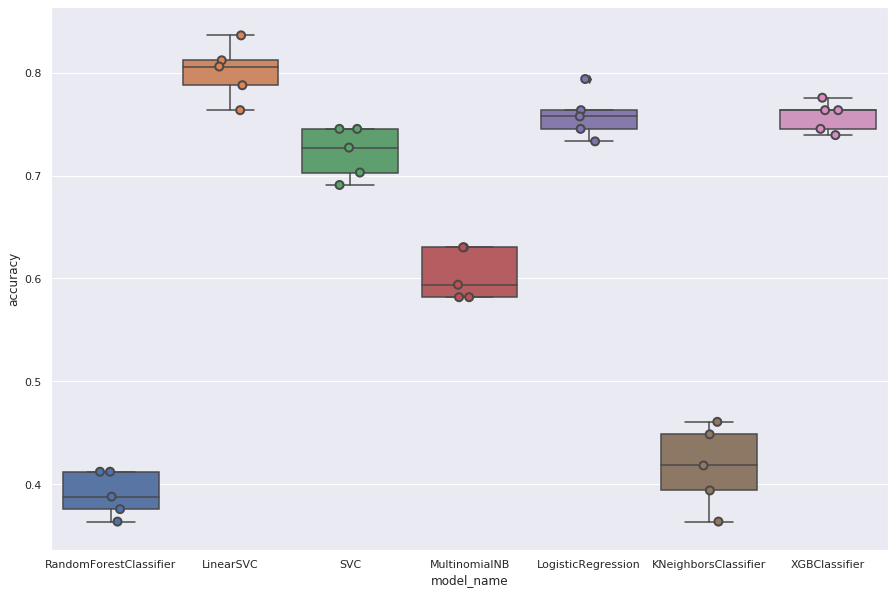

In [22]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [23]:
# Fit ensembled models and predict

In [24]:
# Fit a Linear SVC model
linearsvc = LinearSVC()
linearsvc.fit(C_train, y_train)
# Predict test set
y_predict_lsvc = linearsvc.predict(C_test)
# Print accuracy
print("Linear SVC accuracy: ", accuracy_score(y_test, y_predict_lsvc))

Linear SVC accuracy:  0.7729468599033816


In [25]:
# Show scores for each category
print(classification_report(y_test, y_predict_lsvc, target_names=label_set))

                precision    recall  f1-score   support

         Other       0.94      1.00      0.97        30
Cryptocurrency       0.93      0.87      0.90        15
      Security       0.94      0.62      0.75        24
          Porn       0.68      0.72      0.70        39
      Services       0.00      0.00      0.00        10
   Counterfeit       0.89      0.73      0.80        11
      NoAccess       1.00      0.50      0.67        10
        Market       0.69      0.90      0.78        68

      accuracy                           0.77       207
     macro avg       0.76      0.67      0.69       207
  weighted avg       0.76      0.77      0.75       207



In [26]:
# Fit a SVC model
svc = SVC()
svc.fit(C_train, y_train)
# Predict test set
y_predict_svc = svc.predict(C_test)
# Print accuracy
print("SVC accuracy: ", accuracy_score(y_test, y_predict_svc))

SVC accuracy:  0.6859903381642513


In [27]:
# Show scores for each category
print(classification_report(y_test, y_predict_svc, target_names=label_set))

                precision    recall  f1-score   support

         Other       1.00      0.83      0.91        30
Cryptocurrency       1.00      0.67      0.80        15
      Security       1.00      0.54      0.70        24
          Porn       0.87      0.51      0.65        39
      Services       0.00      0.00      0.00        10
   Counterfeit       1.00      0.55      0.71        11
      NoAccess       1.00      0.10      0.18        10
        Market       0.52      0.99      0.68        68

      accuracy                           0.69       207
     macro avg       0.80      0.52      0.58       207
  weighted avg       0.77      0.69      0.66       207



/home/mwsb/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# Fit a Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(C_train, y_train)
# Predict test set
y_predict_log = log_reg.predict(C_test)
# Print accuracy
print("Logistic Regression accuracy: ", accuracy_score(y_test, y_predict_log))

Logistic Regression accuracy:  0.714975845410628


In [29]:
# Show scores for each category
print(classification_report(y_test, y_predict_log, target_names=label_set))

                precision    recall  f1-score   support

         Other       0.96      0.90      0.93        30
Cryptocurrency       1.00      0.67      0.80        15
      Security       0.81      0.54      0.65        24
          Porn       0.76      0.67      0.71        39
      Services       0.00      0.00      0.00        10
   Counterfeit       0.86      0.55      0.67        11
      NoAccess       1.00      0.10      0.18        10
        Market       0.59      0.96      0.73        68

      accuracy                           0.71       207
     macro avg       0.75      0.55      0.58       207
  weighted avg       0.74      0.71      0.69       207



/home/mwsb/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
# Fit a XGBoost model
xgb = XGBClassifier()
xgb.fit(C_train, y_train)
# Predict test set
y_predict_xgb = xgb.predict(C_test)
# Print accuracy
print("XGBoost Classifier accuracy: ", accuracy_score(y_test, y_predict_xgb))

XGBoost Classifier accuracy:  0.7729468599033816


In [31]:
# Show scores for each category
print(classification_report(y_test, y_predict_xgb, target_names=label_set))

                precision    recall  f1-score   support

         Other       1.00      0.90      0.95        30
Cryptocurrency       1.00      0.80      0.89        15
      Security       0.67      0.58      0.62        24
          Porn       0.62      0.85      0.72        39
      Services       1.00      0.10      0.18        10
   Counterfeit       1.00      0.73      0.84        11
      NoAccess       0.83      0.50      0.62        10
        Market       0.76      0.88      0.82        68

      accuracy                           0.77       207
     macro avg       0.86      0.67      0.71       207
  weighted avg       0.80      0.77      0.76       207



In [32]:
# Create a dictionary of our models
estimators=[('linearsvc', linearsvc), ('svc', svc), ('log_reg', log_reg), ('xgb', xgb)]
# Only include Linear SVC
# estimators=[('linearsvc', linearsvc)]
# Create our voting classifier, inputting our models
ensemble = StackingClassifier(estimators, final_estimator=linearsvc, cv=10)
# Fit model to training data
ensemble.fit(C_train, y_train)
# Predict test set
y_predict_en = ensemble.predict(C_test)
# Print accuracy
print("Ensembled model accuracy: ", accuracy_score(y_test, y_predict_en))

Ensembled model accuracy:  0.7971014492753623


/home/mwsb/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
# Show scores for each category
print(classification_report(y_test, y_predict_en, target_names=label_set))

                precision    recall  f1-score   support

         Other       0.97      1.00      0.98        30
Cryptocurrency       1.00      0.87      0.93        15
      Security       0.89      0.71      0.79        24
          Porn       0.73      0.77      0.75        39
      Services       0.25      0.10      0.14        10
   Counterfeit       0.80      0.73      0.76        11
      NoAccess       1.00      0.50      0.67        10
        Market       0.73      0.90      0.80        68

      accuracy                           0.80       207
     macro avg       0.80      0.70      0.73       207
  weighted avg       0.80      0.80      0.79       207



In [34]:
# Predict categories of unlabelled onions
y_unlabelled = ensemble.predict(C_tfidf_unlabelled)
predict_class = le.inverse_transform(y_unlabelled)
df_unlabelled_eng['predict_class'] = predict_class
df_unlabelled_eng

/home/mwsb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,cluster_name,domain,url,title,body_text,body_token,title_token,language,predict_class
0,! CLONED CARDS !,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,['mhcge66dpacblyp55fv2i7bf37qg22xe34b4hcz2vyxp...,[! CLONED CARDS !],"[! CLONED CARDS !, Home, Price, Shipping, Ques...","[clone, card, home, price, ship, question, con...","[clone, card]",en,Counterfeit
1,$$ The Green Machine $$ - Error,['he22pncoselnm54h'],['he22pncoselnm54h.onion'],[$$ The Green Machine $$ - Error ],[$$ The Green Machine $$ - Error You have been...,"[machin, error, log, session, ha, expir, pleas]","[machin, error]",en,NoAccess
2,$$$ Credit Cards | PayPal | Wester Union | Mon...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,['2cardsowr7u7uvpyrnc5lxuclhb4noj6q2cqf2so7ezg...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,[$$$ Credit Cards | PayPal | Wester Union | Mo...,"[credit, card, wester, union, moneygram, accou...","[credit, card, wester, union, moneygram, accou...",en,Counterfeit
3,&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&#...,['darkfailllnkf4vf'],['darkfailllnkf4vf.onion'],[&#x64;&#65279;&#x61;&#x72;&#x6B;&#x2E;&#x66;&...,"[d﻿ark.fai﻿l: Which darknet sites are online?,...","[ark, darknet, site, onlin, darknet, site, onl...","[darknet, site, onlin]",en,Services
4,&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dres...,['rvy6qmlqfstv6rlz'],['rvy6qmlqfstv6rlz.onion'],[&lt;&lt;&lt;/&gt;&gt; Chaos Computer Club Dre...,"[<<</>> Chaos Computer Club Dresden | c3d2, <<...","[chao, comput, club, dresden, chao, comput, cl...","[lt, lt, lt, gt, gt, chao, comput, club, dresden]",en,Services
...,...,...,...,...,...,...,...,...,...
1304,| TheYOSH.nl,['ctzzqqimlfamyhrc'],['ctzzqqimlfamyhrc.onion'],[| TheYOSH.nl],"[| TheYOSH.nl, Skip to main content, User acco...","[theyosh, nl, skip, content, user, account, me...","[theyosh, nl]",en,Services
1321,✉ Guerrilla Mail on Tor,['grrmailb3fxpjbwm'],['grrmailb3fxpjbwm.onion'],[✉ Guerrilla Mail on Tor],"[✉ Guerrilla Mail on Tor, TorGuerrillaMail - D...","[guerrilla, mail, tor, dispos, mail, address, ...","[guerrilla, mail, tor]",en,Services
1322,✔ Legit Carding Services ♛ Money Transfer Worl...,['greenegbqkyk3ois'],['greenegbqkyk3ois.onion'],[✔ Legit Carding Services ♛ Money Transfer Wor...,[✔ Legit Carding Services ♛ Money Transfer Wor...,"[card, servic, money, transfer, worldwid, webs...","[card, servic, money, transfer, worldwid, webs...",en,Counterfeit
1331,约伊兹的萌狼乡手札,"['horoiomuy6xignjv', 'qty3gmiq3zhs7whorla4ynvm...","['horoiomuy6xignjv.onion', 'qty3gmiq3zhs7whorl...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]","[约伊兹的萌狼乡手札, vertical_align_top重新开始？🙃, menu, 约伊...","[约伊兹的萌狼乡手札, menu, 约伊兹的萌狼乡手札, more_vert, ホロ, 且被...","[约伊兹的萌狼乡手札, 约伊兹的萌狼乡手札]",en,Services


In [35]:
# Count number of clusters in each category
df_unlabelled_eng_count = df_unlabelled_eng[['cluster_name', 'predict_class']].groupby(['predict_class']).count()
df_unlabelled_eng_count = df_unlabelled_eng_count.sort_values(by=['cluster_name'], ascending=False)
df_unlabelled_eng_count.reset_index(inplace=True)
df_unlabelled_eng_count

,predict_class,cluster_name
0,Counterfeit,433
1,Services,369
2,Market,133
3,NoAccess,73
4,Cryptocurrency,71
5,Other,31
6,Security,30
7,Porn,27


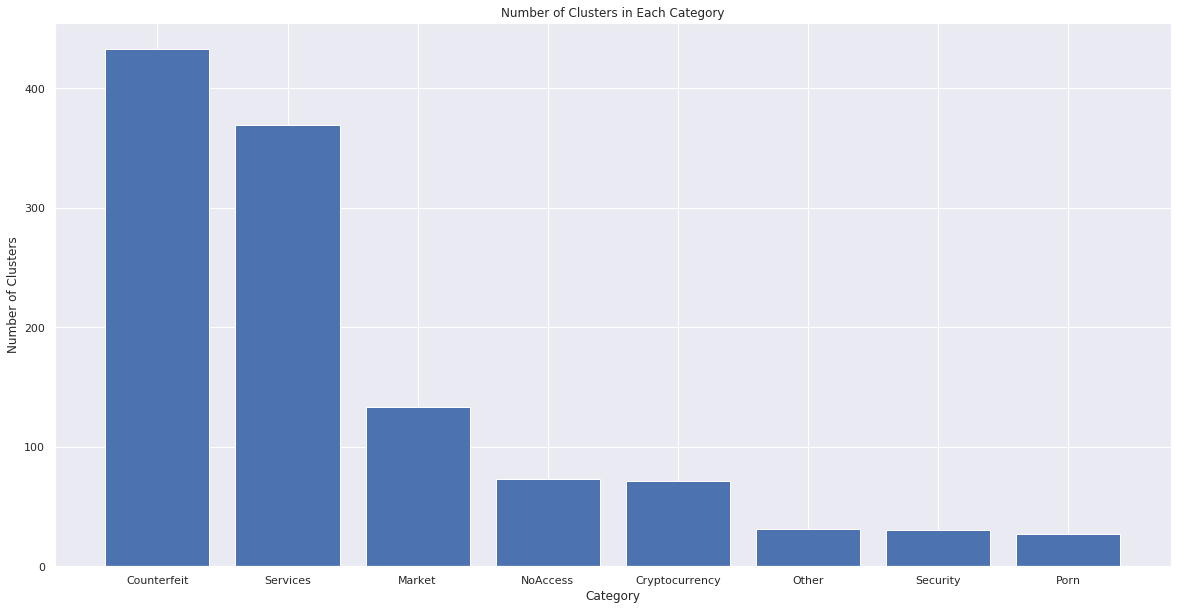

In [36]:
plt.figure(figsize=(20,10))
plt.bar(df_unlabelled_eng_count['predict_class'], df_unlabelled_eng_count['cluster_name'])
plt.xlabel("Category")
plt.ylabel("Number of Clusters")
plt.title("Number of Clusters in Each Category")
plt.show()

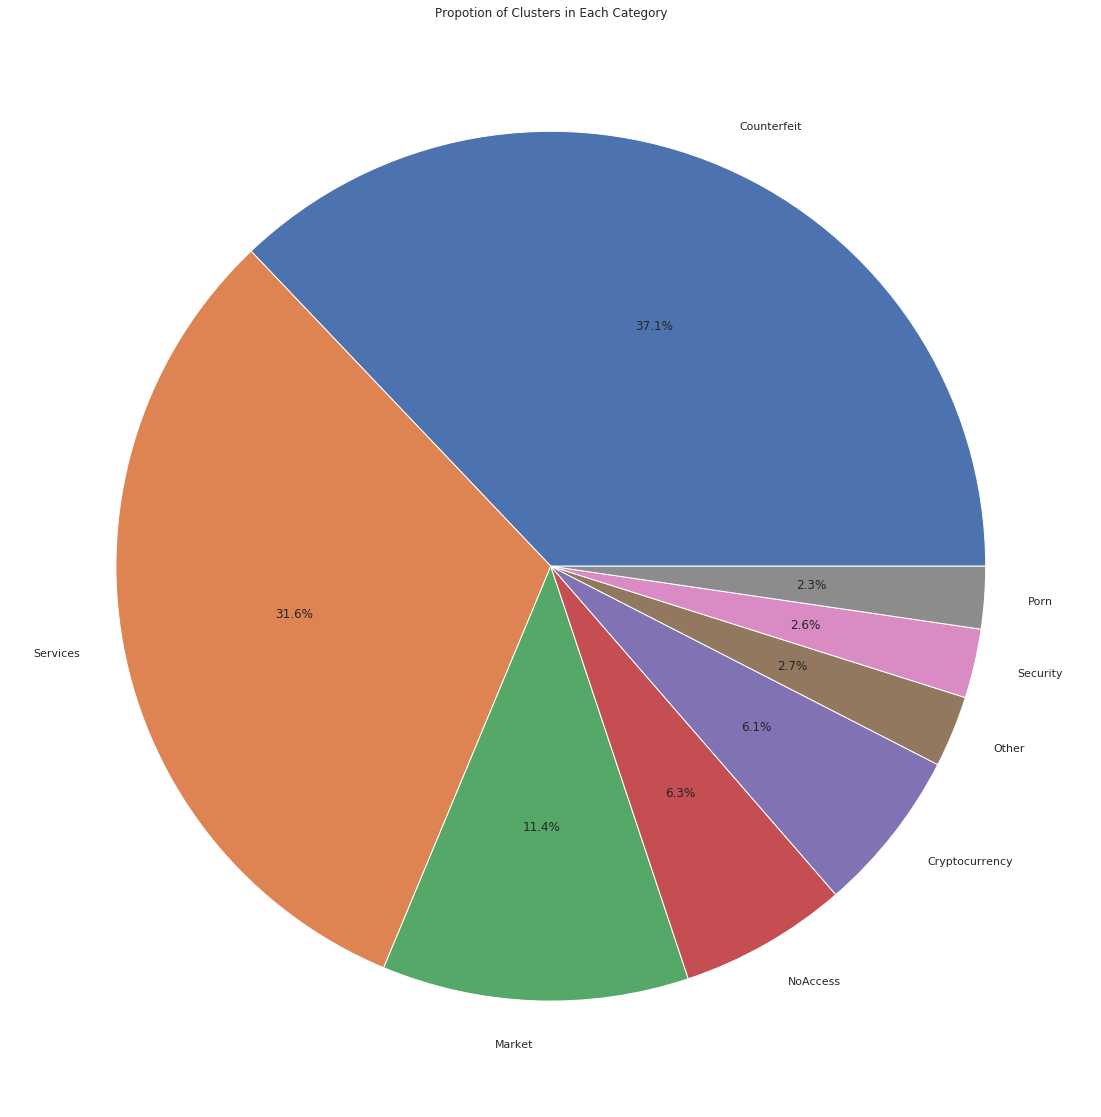

In [37]:
plt.figure(figsize=(20,20))
plt.pie(df_unlabelled_eng_count['cluster_name'], labels=df_unlabelled_eng_count['predict_class'], autopct='%1.1f%%')
plt.title("Propotion of Clusters in Each Category")
plt.show()

In [38]:
# df_unlabelled_eng.to_csv('../data/predict_set.csv')